# **Financial Market Price Estimation with Kalman Filters**

-----

## **Introduction to Kalman Filters**

Kalman Filters are named after [Rudolf Kalman](https://en.wikipedia.org/wiki/Rudolf_E._K%C3%A1lm%C3%A1n), who developed the technique. They are used in many applications, such as control systems, signal processing, navigation systems etc. Kalman filters were utilized during the `Apollo Program`, and have also found use in NASA space shuttles, navy submarines, unmanned aerospace vehicles, and rocket-based weapons like cruise missiles. However they are also used in civilian location tracking applications such as the GPS system in your car.

**The unique value proposition of Kalman Filters is that they provide an efficient way to estimate the state of a process. They support the estimation of past, present, and future states even when the precise model of the system is unknown.**

Kalman Filters are most commonly used when: 
- The variables of interest can not be measured directly
- The measurements available from multiple sources are subject to noise

Kalman Filters are quite ostensibly an unsupervised machine learning algorithm for tracking a single object in continuous state space. 

Given a sequence of noisy measurements, Kalman Filters are able to recover the **true state** of the underlying object being tracked, by combining measurements and predictions to find an optimum estimate of the target value.

Kalman Filters involve two steps: 
- **The Prediction step**, which predicts the current state estimate
- **The Update step**, which adjusts the predicted estimate by an actual measurement

The above two steps continue to find an optimal estimate of the target value.



> ![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/image.png)



Some of the different types of Kalman Filters are:

|State Estimator|Model|Assumed Distribution|
| --- | --- | --- |
|Kalman Filter|Linear|Gaussian|
|Extended Kalman Filter|Locally Linear|Gaussian|
|Unscented Kalman Filter|Nonlinear|Gaussian|
|Particle Filter|Nonlinear|Non Gaussian|

### **Case Study - Context**

In financial market trading, Kalman Filters are also extensively used to produce estimates of prices and correlations. They use a timeframe of observed noisy prices to create a price estimate. 

In this case study, we will: 
- Design a Kalman estimator to replace moving average signals
- Use a Kalman filter to estimate regression coefficients

Kalman Filters are typically used in momentum trading strategies where the trading signal is generated by a moving average crossover. They are also used to dynamically adjust the hedge ratio in a mean reverting trading strategy.

### **Kalman Filter as Moving Average**

As the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is estimation of rolling parameters of the data. This is similar to computing exponentially weighted moving average (`EWMA`), but not exactly the same as when we use a Kalman filter, there's `no window length` that we need to specify. This is useful for computing the moving average or for smoothing out estimates of other quantities. For instance, if we have already computed the moving target (e.g any finanical metric like sharpe ratio), we can smooth it using a Kalman filter.

Below, we'll use both a Kalman filter and an n-day moving average to estimate the rolling mean of a dataset. We hope that the mean describes our observations well, so it shouldn't change too much when we add an observation; therefore, we assume that it evolves as a random walk with a small error term. The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.

-------------------
### **Dataset**


We will load price data for `MSFT` (Microsoft) stock from time period `2021-01-01` till `2022-01-01` and will construct a kalman filter to calculate rolling mean of prices for `MSFT`. We will assume `transition` and `observation` matrices equal to 1 and initial guess for the mean is 0. Then we will compare kalman estimate of the rolling mean to 30, 60 and 90 day moving averages for the same price series.

#### **Installing pykalman library**

- We will be using a new library - `pykalman` for implementing kalman filter.
- Please use the following code to `install the pykalman` library. You only do it **once** while running the code for the first time.


In [ ]:
# Installing pykalman library
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Importing the necessary libraries**

In [ ]:
# Importing numpy for working with arrays
import numpy as np

# Importing pandas for data manipulation
import pandas as pd

# Importing function to apply mathematical operations on polynomials
from scipy import poly1d

# Importing matplotlib for data visualization
import matplotlib.pyplot as plt

# Importing pykalman to implement kalman filter
from pykalman import KalmanFilter

# Importing pandas_datareader to fetch data from yahoo finance
import pandas_datareader.data as web

# To ignore warnings in jupyter notebook
import warnings
warnings.filterwarnings('ignore')

### **Loading the price data**

In [ ]:
# Fetching price data for MSFT from yahoo finance 2021-01-01 till 2022-01-01
msft_price = web.DataReader('MSFT', 'yahoo', start='2021-01-01', end='2022-01-01')

# We are only interested to compute moving average for adjusted close price
msft_price = msft_price['Adj Close']

In [ ]:
# Showing price data
msft_price

Date
2021-01-04    214.934372
2021-01-05    215.141693
2021-01-06    209.563232
2021-01-07    215.526779
2021-01-08    216.839920
                 ...    
2021-12-27    340.949280
2021-12-28    339.754517
2021-12-29    340.451477
2021-12-30    337.832977
2021-12-31    334.846130
Name: Adj Close, Length: 252, dtype: float64

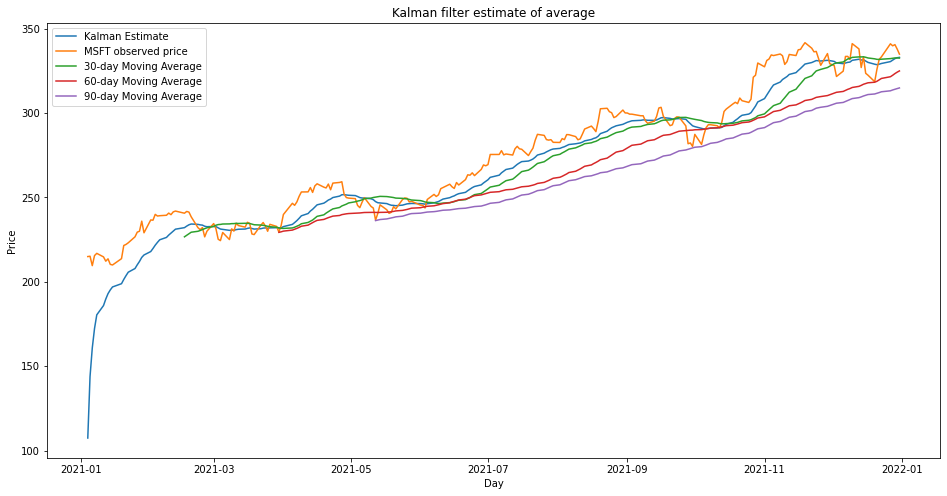

In [ ]:
# Constructing a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Computing rolling mean using the observed values of the price
state_means, _ = kf.filter(msft_price.values)
state_means = pd.DataFrame({'index':msft_price.index, 'states':state_means.flatten()}).set_index('index')['states']

# Computing the rolling mean with various lookback windows i.e. 30, 60 and 90 days
mean30 = msft_price.rolling(30).mean()
mean60 = msft_price.rolling(60).mean()
mean90 = msft_price.rolling(90).mean()

# Plotting original data and estimated mean
figure = plt.figure(figsize=(16, 8))
plt.plot(state_means)
plt.plot(msft_price)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'MSFT observed price', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

We will zoom into a specific section of this above plot, to look at it more closely

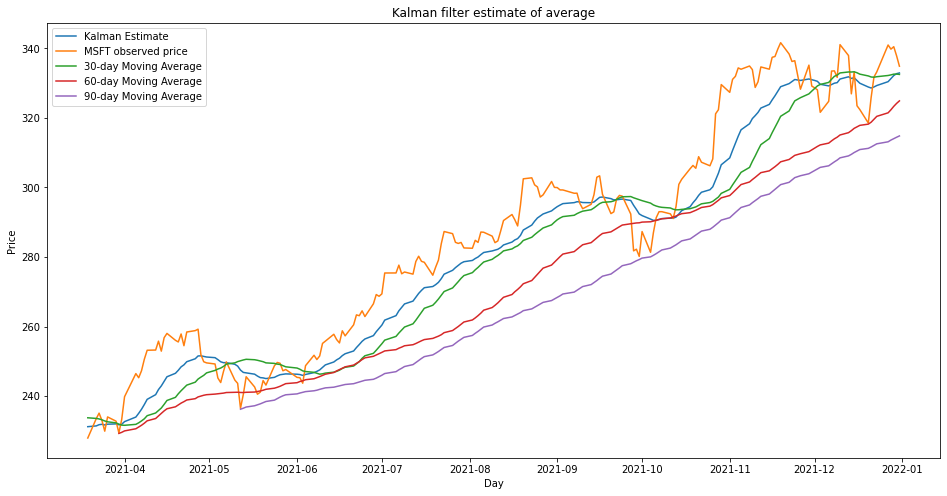

In [ ]:
figure = plt.figure(figsize=(16, 8))
plt.plot(state_means[-200:])
plt.plot(msft_price[-200:])
plt.plot(mean30[-200:])
plt.plot(mean60[-200:])
plt.plot(mean90[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'MSFT observed price', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

As we can observe from above plot, kalman filter is more rigorous than a moving average and generally better than 30, 60 and 90 moving averages. The advantage of the Kalman filter is that we don't need to select a `window length`, so we run less risk of overfitting. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define.

### **Linear Regression**

Now we will use a Kalman filter to find linear regression lines for a dataset. We'll be comparing a MSFT stock price with the S&P 500, so the result will be a sort of rolling alpha and beta for the stock, where $\alpha$ and $\beta$ are the parameters of the linear regression equation $$ y_t \approx \alpha + \beta x_t $$

Below we use colors to indicate the dates that the data points $(x_t, y_t)$ correspond to.

In [ ]:
# Fetching price data for MSFT from yahoo finance 2021-01-01 till 2022-01-01
msft_price = web.DataReader('MSFT', 'yahoo', start='2021-01-01', end='2022-01-01')[['Adj Close']]

# Fetching price data for S&P 500 from yahoo finance 2021-01-01 till 2022-01-01
snp_price = web.DataReader('sp500', 'fred', start='2021-01-01', end='2022-01-01')

# Joining MSFT and S&P 500 to create one single dataframe
joined_data = pd.concat([msft_price, snp_price], axis=1)

# Dropping those date with missing values
joined_data = joined_data.dropna()

# Showing head of the dataset
joined_data.head()

,Adj Close,sp500
2021-01-04,214.934372,3700.65
2021-01-05,215.141693,3726.86
2021-01-06,209.563217,3748.14
2021-01-07,215.526749,3803.79
2021-01-08,216.839935,3824.68


Visualizing the above two time series as a scatterplot and color represents different dates

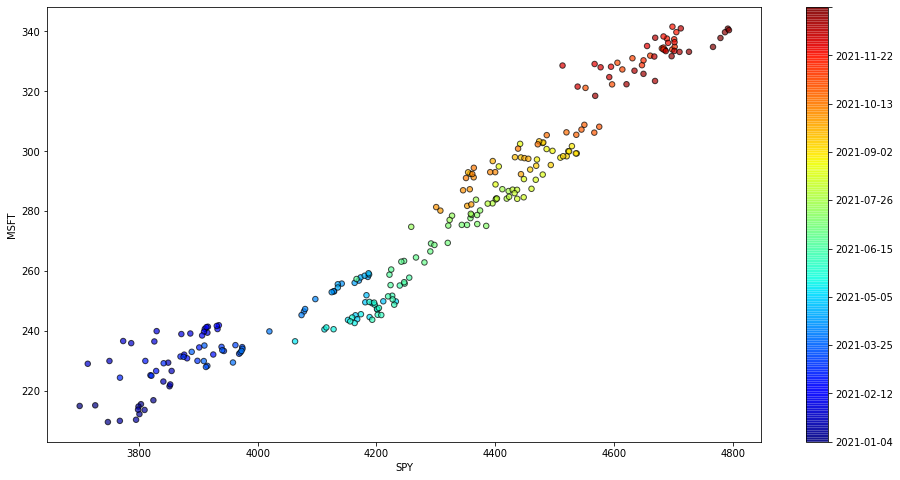

In [ ]:
figure = plt.figure(figsize=(16, 8))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(joined_data['sp500']))
sc = plt.scatter(joined_data['sp500'], joined_data['Adj Close'], s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in joined_data['sp500'][::len(joined_data['sp500'])//9].index])
plt.xlabel('SPY')
plt.ylabel('MSFT');

Let's assume that the state of our system is the line that the observations are following, with parameters $\alpha$ and $\beta$. Our inital guesses for these parameters is (0, 0), with a covariance matrix (which describes the error of our guess) of all ones. As in the example of the rolling mean, we assume that our parameters follow a random walk (transition matrix is the identity) with a small error term (transition covariance is a small number times the identity).

To get from the state of our system to an observation, we multiply the state $(\beta, \alpha)$ with $(x_i, 1)$ to get $\beta x_i + \alpha \approx y_i$, so our observation matrix is just a column of 1s glued to $x$. We assume that the variance of our observations $y$ is 2. Now we are ready to use our observations of $y$ to evolve our estimates of the parameters $\alpha$ and $\beta$.

In [ ]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.expand_dims(np.vstack([[joined_data['sp500']], [np.ones(len(joined_data['sp500']))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [ ]:
# Using the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(joined_data['Adj Close'])

Below we plot the means - that is, our best estimates - of $\alpha$ and $\beta$ over time.

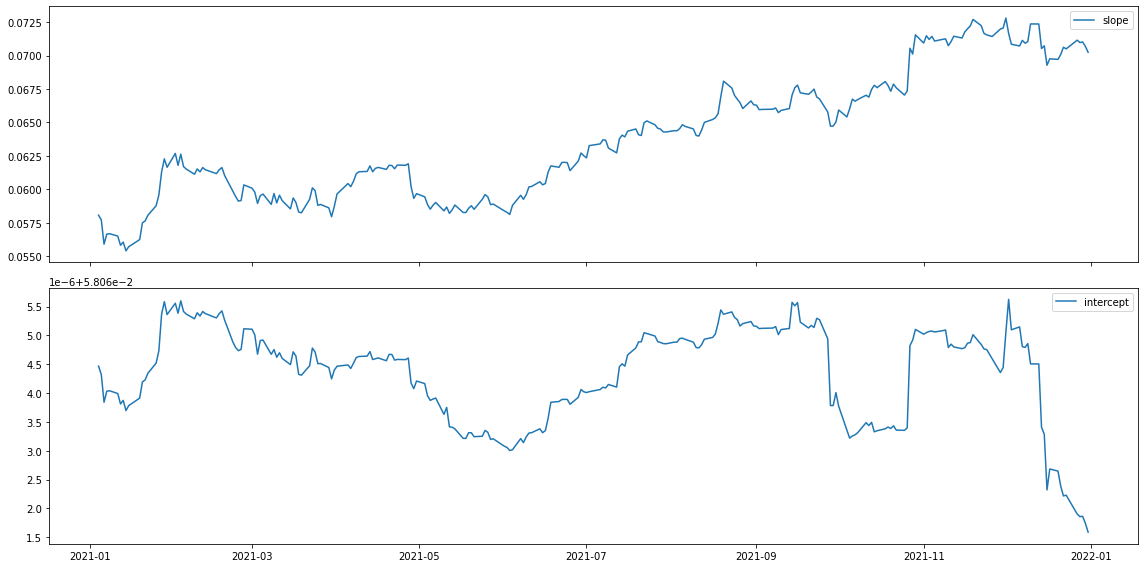

In [ ]:
_, axarr = plt.subplots(2, sharex=True, figsize=(16, 8))
axarr[0].plot(joined_data['sp500'].index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(joined_data['sp500'].index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

We can see from above how much the parameters fluctuate over long periods of time. If we are basing a trading algorithm on this, such as something that involves beta hedging, it's important to have the best and most current estimate of the beta. To visualize how the system evolves through time, we plot every fifth state (linear model) below. For comparison, in black we have the line returned by using ordinary least-squares regression on the full dataset, which is very different.

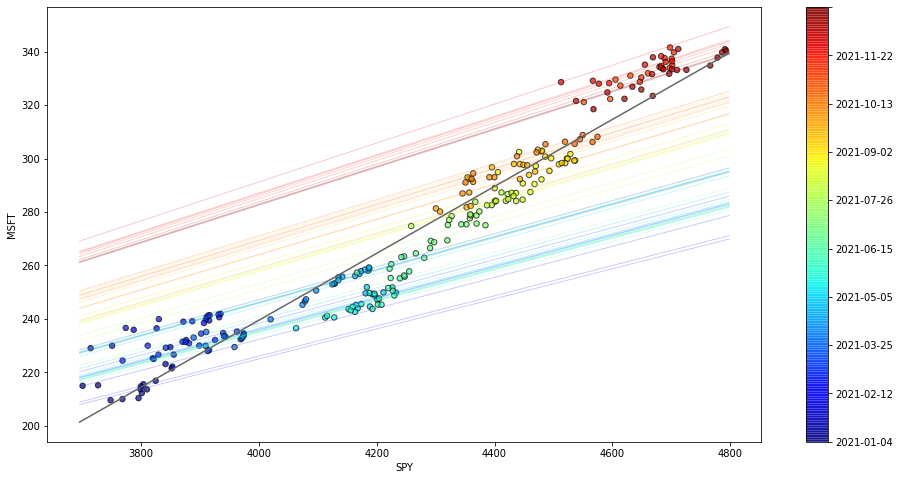

In [ ]:
figure = plt.figure(figsize=(16, 8))

# Plotting data points using colormap
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(joined_data['sp500']))
sc = plt.scatter(joined_data['sp500'], joined_data['Adj Close'], s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in joined_data['sp500'][::len(joined_data['sp500'])//9].index])

# Plotting every fifth line
step = 5
xi = np.linspace(joined_data['sp500'].min()-5, joined_data['sp500'].max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plotting the OLS regression line
plt.plot(xi, poly1d(np.polyfit(joined_data['sp500'], joined_data['Adj Close'], 1))(xi), '0.4')

# Labelling axes
plt.xlabel('SPY')
plt.ylabel('MSFT');

In the above chart we can see that although each of the state estimates takes into account all previous observations, they fit the more recent data better than the older data. This allows the filter to adapt to structural changes in the data over time. 

Below we will compute the returns from the price data and then run the kalman filter to estimate $\alpha$ and $\beta$ for returns. Here also we are plotting every fifth estimate in order to minimize clutter.

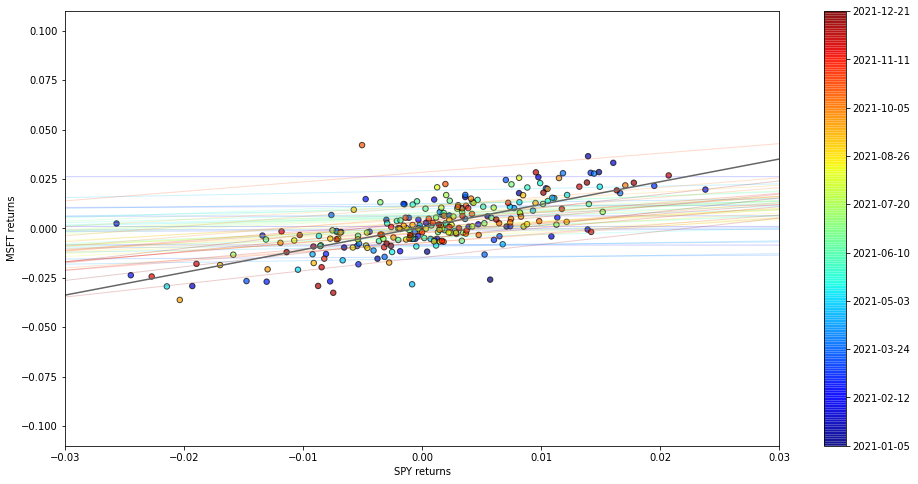

In [ ]:
figure = plt.figure(figsize=(16, 8))
# Getting returns from pricing data
x_r = joined_data['sp500'].pct_change()[1:]
y_r = joined_data['Adj Close'].pct_change()[1:]

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plotting data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x_r[::len(x_r)//9].index])

# Plotting every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plotting the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjusting axes for visibility
plt.axis([-0.03,0.03,-0.11, 0.11])

# Labelling axes
plt.xlabel('SPY returns')
plt.ylabel('MSFT returns');

From above plot we can see that, although the raw data is much more jumbled here, we can see the regression line evolving. The estimate of beta increases gradually from around 0 to about the same as the ordinary least squares regression shown by heavier black line.  

### **Additional Reading**

[Predicting Market Data with a Kalman Filter](https://haikulabs.com/pmdwkf26.htm#intro)